In [11]:
#setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from librosa import display
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import ReduceLROnPlateau

In [7]:
#make data to csv
import csv

# Path to the main dataset folder
dataset_path = 'dataset'  # Replace with the actual path

# Path to save the CSV file
csv_file_path = 'train.csv'

# Open the CSV file in write mode
with open(csv_file_path, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    
    # Write the header
    csv_writer.writerow(['name', 'status'])
    
    # Loop through each folder in the dataset
    for folder_name in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder_name)
        
        # Check if it's a folder
        if os.path.isdir(folder_path):
            # Loop through each file in the folder
            for file_name in os.listdir(folder_path):
                # Write the file name and folder name (status) to the CSV
                csv_writer.writerow([file_name, folder_name])
                
df = pd.read_csv(csv_file_path)
print(df)
#df = pd.head(csv_file_path)
print(f"CSV file '{csv_file_path}' created successfully.")

                                            name   status
0     01567151-7bb2-45ee-9aa8-a1332b5941ea_0.wav    covid
1     01567151-7bb2-45ee-9aa8-a1332b5941ea_1.wav    covid
2     038592cb-c8db-4f55-8052-e20059146cb5_0.wav    covid
3     038592cb-c8db-4f55-8052-e20059146cb5_1.wav    covid
4     03d30b8b-03f8-4089-bda8-0e14deec7d82_0.wav    covid
...                                          ...      ...
1284  fdbabb79-c296-4b93-9e02-06b290916fe7_3.wav  healthy
1285  fdbabb79-c296-4b93-9e02-06b290916fe7_4.wav  healthy
1286  fe28d452-dc48-4c86-af5c-d8cee2e7105b_0.wav  healthy
1287  fe28d452-dc48-4c86-af5c-d8cee2e7105b_1.wav  healthy
1288  fe28d452-dc48-4c86-af5c-d8cee2e7105b_2.wav  healthy

[1289 rows x 2 columns]
CSV file 'train.csv' created successfully.


C:\Users\Airpo\AppData\Local\Temp\ipykernel_5968\4201580779.py:18: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])
C:\Users\Airpo\AppData\Local\Temp\ipykernel_5968\4201580779.py:18: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])


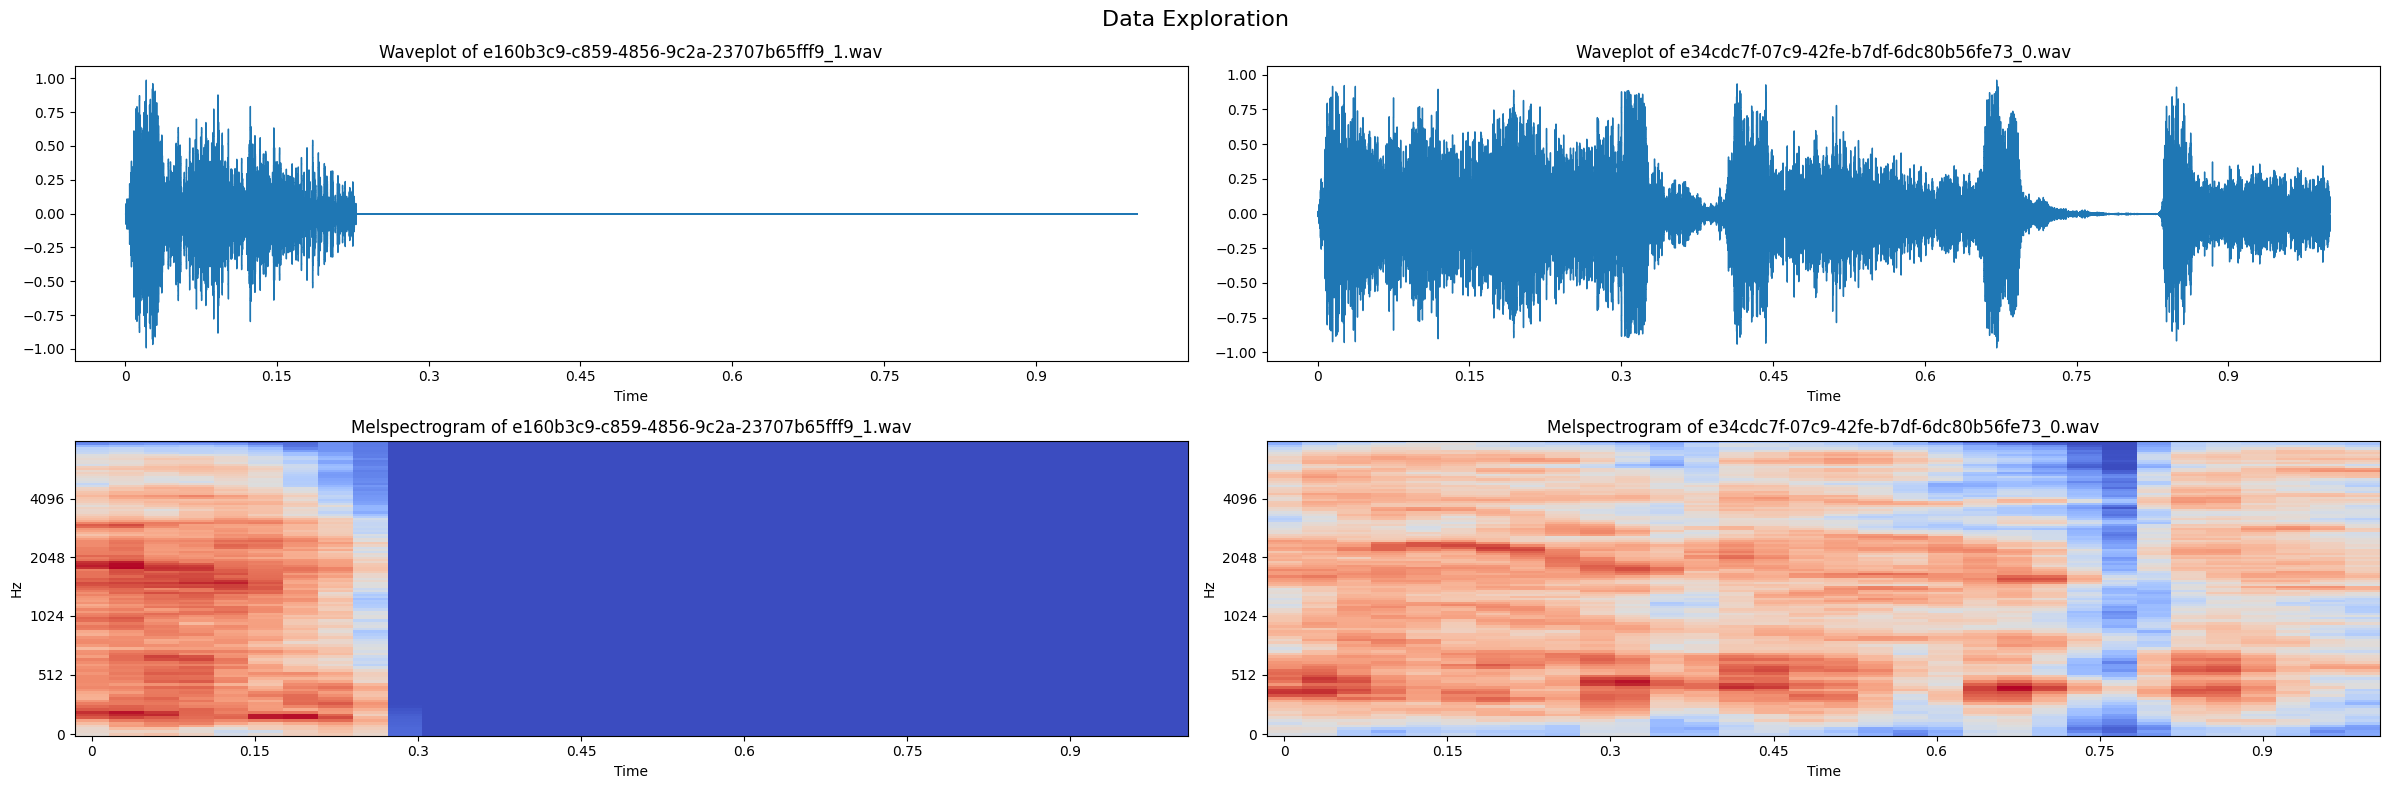

In [ ]:
status = ["healthy", "covid"]

# Load the CSV file
description = pd.read_csv('train.csv')

# Create subplots
fig, axs = plt.subplots(nrows=2, ncols=len(status))
axs = axs.flatten()
fig.suptitle('Data Exploration', fontsize=16)
fig.set_size_inches(24, 8)

for i, digit in enumerate(status):
    # Select a random file for the selected status
    rand_file = np.random.choice(description[description['status'] == digit]['name'])
    
    # Load audio and plot waveform and melspectrogram
    audio, sr = librosa.load(os.path.join('dataset', digit, rand_file), sr=None)
    librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])
    axs[i].set(title=f'Waveplot of {rand_file}')
    
    mels_db = librosa.power_to_db(S=librosa.feature.melspectrogram(y=audio, sr=sr), ref=1.0)
    librosa.display.specshow(data=mels_db, sr=sr, x_axis='time', y_axis='mel', ax=axs[i+len(status)])
    axs[i+len(status)].set(title=f'Melspectrogram of {rand_file}')

plt.tight_layout()
plt.show()

In [10]:
# Create features from audio files
features = []
labels = []

for index, row in description.iterrows():
    file_path = os.path.join('dataset', row['status'], row['name'])
    
    # Check if file exists before loading
    if os.path.isfile(file_path):
        audio, sr = librosa.load(file_path, sr=None)
        mels_db = librosa.power_to_db(librosa.feature.melspectrogram(y=audio, sr=sr), ref=1.0)
        
        # Add a new axis to convert from (height, width) to (height, width, 1)
        mels_db = np.expand_dims(mels_db, axis=-1)  # Add channel dimension
        
        features.append(mels_db)
        labels.append(row['status'])
    else:
        print(f"File not found: {file_path}")

# Convert to numpy arrays after loading
features = np.array(features)
labels = np.array(labels)

# Check if features is empty
if len(features) == 0:
    print("No audio features loaded. Please check your dataset paths.")
else:
    print(f"Loaded {len(features)} audio features.")

# Continue with encoding labels and building the model as before

Loaded 1289 audio features.


In [16]:
# Encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Check how many classes you have
num_classes = len(label_encoder.classes_)

# Adjust output layer size based on the number of classes
model = keras.Sequential(layers=[
    keras.layers.InputLayer(input_shape=(128, 32, 1)),  # Adjust the input shape if necessary

    keras.layers.Conv2D(8, (3, 3), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),  # 2x2 MaxPooling

    keras.layers.Conv2D(8, (3, 3), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])


# Set parameters for data splitting and training
TEST_SIZE = 0.2
BATCH_SIZE = 256
EPOCHS = 100 

# One-hot encode labels; depth should match the number of classes
encoded_labels = label_encoder.fit_transform(labels).astype(np.int32)  # แปลงเป็น int32

# One-hot encoding labels
encoded_labels = tf.one_hot(indices=encoded_labels, depth=num_classes)

# Split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels.numpy(), test_size=TEST_SIZE)

# Train the model with early stopping and model checkpoint
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)

# Set up the learning rate reduction
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0000000001)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 128, 32, 8)     │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 32, 8)     │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 16, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 16, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 8, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32, 8, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 8, 16)      │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 8, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 4, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16, 4, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 4, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 4, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,970 (58.48 KB)

 Trainable params: 14,842 (57.98 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 429ms/step - accuracy: 0.5001 - loss: 2.0392 - val_accuracy: 0.5121 - val_loss: 1.1800 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 529ms/step - accuracy: 0.5416 - loss: 1.2344 - val_accuracy: 0.5169 - val_loss: 0.7932 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step - accuracy: 0.6342 - loss: 0.9099 - val_accuracy: 0.5845 - val_loss: 0.6862 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - accuracy: 0.6097 - loss: 0.7403 - val_accuracy: 0.5652 - val_loss: 0.6965 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step - accuracy: 0.5868 - loss: 0.7143 - val_accuracy: 0.5797 - val_loss: 0.6797 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - accuracy: 0.6055 - loss: 0.6776 - val_accuracy: 0.5604 - val_loss: 0.6819 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step - accuracy: 0.6374 - loss: 0.6409 - val_acc

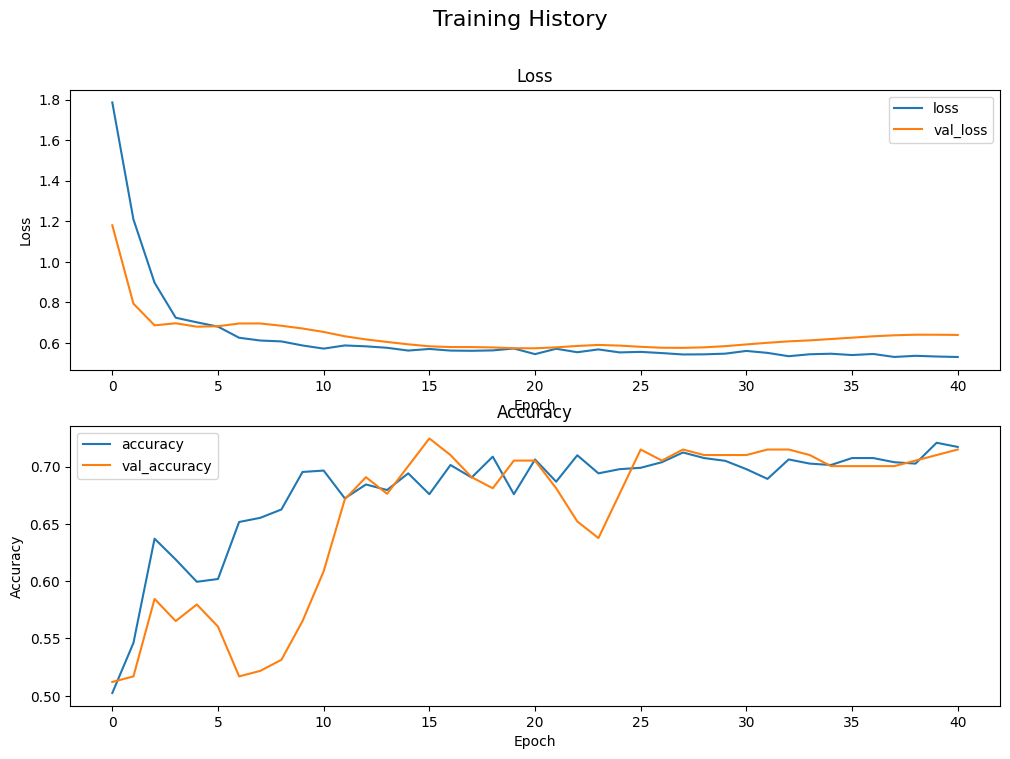

In [17]:
# Train the model
history = model.fit(x=X_train, y=y_train, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

# Plot the training history
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])

axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()

In [96]:
# Save the trained model
model.save('model.keras')

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


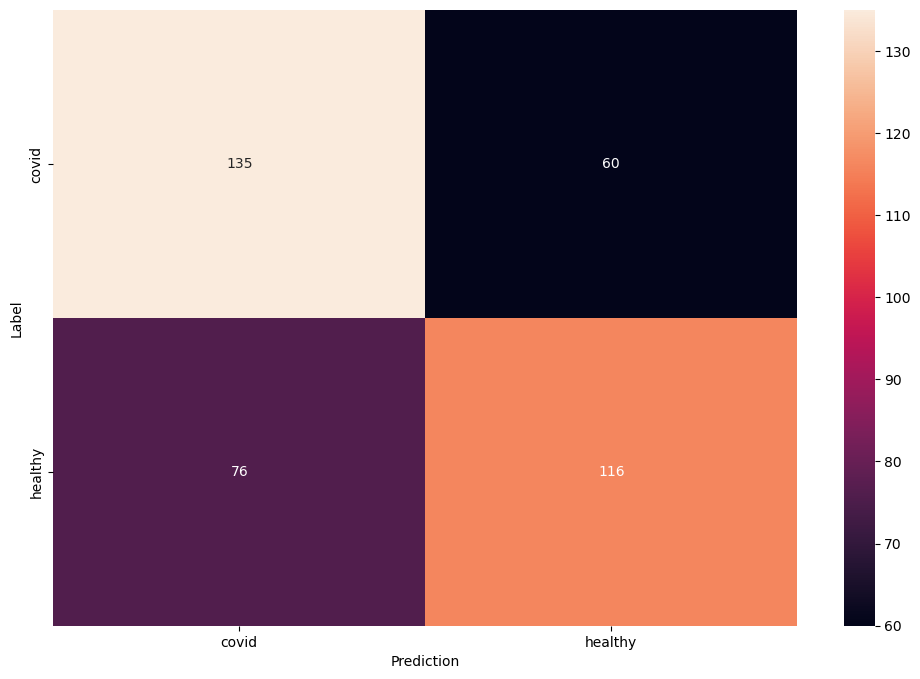

In [ ]:
y_predicted = np.argmax(model.predict(x=X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
label_names = np.unique(labels)
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_predicted)
fig = plt.figure()
fig.set_size_inches(12, 8)
sns.heatmap(confusion_matrix, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
import librosa
import numpy as np

# โหลดไฟล์เสียงใหม่
audio_path = '.\dataset\covid\0b618a49-9562-4fa5-afb7-fce583b5a444_2.wav'  # กำหนดที่อยู่ไฟล์เสียงที่ต้องการทำนาย
audio, sr = librosa.load(audio_path, sr=None)

# แปลงเสียงเป็น melspectrogram
mels_db = librosa.power_to_db(librosa.feature.melspectrogram(y=audio, sr=sr), ref=1.0)

# ปรับรูปแบบให้ตรงกับโมเดล
mels_db = np.expand_dims(mels_db, axis=-1)  # เพิ่มมิติช่องสัญญาณ
mels_db = np.expand_dims(mels_db, axis=0)  # เพิ่มมิติ batch

# ทำนายผลลัพธ์
predictions = model.predict(mels_db)

# แปลงผลลัพธ์กลับมาเป็น label
predicted_class = np.argmax(predictions, axis=1)  # เลือกคลาสที่มีค่าความน่าจะเป็นสูงสุด

# แสดงผลลัพธ์
status_labels = label_encoder.classes_  # ชื่อคลาส ["healthy", "covid"]
predicted_label = status_labels[predicted_class[0]]
print(f"ผลการทำนาย: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
ผลการทำนาย: covid
